In [1]:
import torch
import torch.nn as nn
from layer.component import EncoderBlock, DecoderBlock

from PIL import Image
import numpy as np
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

In [2]:
class UnetModel(nn.Module):

    def __init__(self, in_channels, out_channels, model_depth=4, final_activation="sigmoid"):
        super(UnetModel, self).__init__()
        self.encoder = EncoderBlock(in_channels=in_channels, model_depth=model_depth)
        self.decoder = DecoderBlock(out_channels=out_channels, model_depth=model_depth)
        if final_activation == "sigmoid":
            self.sigmoid = nn.Sigmoid()
        else:
            self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x, downsampling_features = self.encoder(x)
        x = self.decoder(x, downsampling_features)
        x = self.sigmoid(x)
        # print("Final output shape: ", x.shape)
        return x


In [3]:
loss_function = torch.nn.MSELoss(reduction='sum')

In [4]:
device_id = f"cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_id)

torch.Size([1, 10, 10])
torch.Size([3, 3, 3])


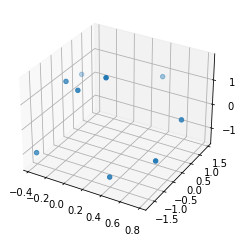

In [10]:
batch_size = (2,)
input_shape = (1,32,32,32)
output_shape = (1,32,32,32)

x = torch.randn(batch_size + input_shape)
y = torch.randn(batch_size + output_shape)

trans = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
    transforms.Grayscale(),
    transforms.Resize((10,10)),
])

trainset = torchvision.datasets.ImageFolder(root=r'image', transform=trans)

# image = Image.open('image/T1W.png')
print(trainset.__getitem__(1)[0].shape)
# a = trainset.__getitem__(1)[0]
print(x.__getitem__(0)[0].shape)
a = x.__getitem__(0)[0]
a = a.permute(1,2,0).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(a[:,0],a[:,1],a[:,2])
plt.show()

In [6]:

model = UnetModel(in_channels=1, out_channels=1)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)

for epoch in range(10):
    # 순전파 단계 : 모델에서 x에 대한 예측 값 y_pred를 계산합니다.
    y_pred = model(x)

    loss = loss_function(y_pred,y)
    scheduler.step(loss)

    print(f"epoch {epoch} | lose : {loss}")

    optimizer.zero_grad()

    # 역전파 단계
    loss.backward()

    # optimizer의 step 함수를 호출 하면 매개 변수가 갱신됨
    optimizer.step()

epoch 0 | lose : 86218.09375
epoch 1 | lose : 84159.640625
epoch 2 | lose : 82471.125
epoch 3 | lose : 80781.890625
epoch 4 | lose : 79046.671875
epoch 5 | lose : 77391.015625
epoch 6 | lose : 75863.421875
epoch 7 | lose : 74441.4375
epoch 8 | lose : 73137.0
epoch 9 | lose : 71963.15625
